In [2]:
%cd /home/aistudio/data/data100731/
!unzip shuju.zip
import pandas as pd
data = pd.read_csv('OCEMOTION.csv', sep='\t',header=None)
data.columns = ["id", "text_a", "label"]

/home/aistudio/data/data100731
Archive:  shuju.zip
  inflating: OCEMOTION.csv           


In [3]:
import re
import os
import shutil
from tqdm import tqdm
from collections import defaultdict


def clean_duplication(text):
    left_square_brackets_pat = re.compile(r'\[+')
    right_square_brackets_pat = re.compile(r'\]+')
    punct = [',', '\\.', '\\!', '，', '。', '！', '、', '\?', '？']

    def replace(string, char):
        pattern = char + '{2,}'
        if char.startswith('\\'):
            char = char[1:]
        string = re.sub(pattern, char, string)
        return string

    text = left_square_brackets_pat.sub('', text)
    text = right_square_brackets_pat.sub('', text)
    for p in punct:
        text = replace(text, p)
    return text

def emoji2zh(text, inverse_emoji_dict):
    for emoji, ch in inverse_emoji_dict.items():
        text = text.replace(emoji, ch)
    return text

def clean_emotion(data_path, emoji2zh_data, save_dir, train=True):
    data = defaultdict(list)
    filename = os.path.basename(data_path)
    with open(data_path, 'r', encoding='utf8') as f:
        texts = f.readlines()
        for line in tqdm(texts, desc=data_path):
            if train:
                id_, text, label = line.strip().split('\t')
            else:
                id_, text = line.strip().split('\t')
            data['id'].append(id_)
            text = emoji2zh(text, emoji2zh_data)
            text = clean_duplication(text)
            data['text_a'].append(text)
            if train:
                data['label'].append(label)
    df = pd.DataFrame(data)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    df.to_csv(os.path.join(save_dir, filename), index=False,
              encoding='utf8', header=False, sep='\t')
    return df

In [4]:
import json
emoji2zh_data = json.load(open('/home/aistudio/emoji2zh.json', 'r', encoding='utf8'))
data = clean_emotion('/home/aistudio/data/data100731/OCEMOTION.csv',emoji2zh_data,'./')

/home/aistudio/data/data100731/OCEMOTION.csv: 100%|██████████| 35694/35694 [00:04<00:00, 7710.48it/s]


In [5]:
data = data[['text_a', 'label']]

In [6]:
data.loc[data['label']=='sadness', 'label'] = '难过'
data.loc[data['label']=='happiness', 'label'] = '愉快'
data.loc[data['label']=='like', 'label'] = '喜欢'
data.loc[data['label']=='anger', 'label'] = '愤怒'
data.loc[data['label']=='fear', 'label'] = '害怕'
data.loc[data['label']=='surprise', 'label'] = '惊讶'
data.loc[data['label']=='disgust', 'label'] = '厌恶'

In [7]:
from sklearn.utils import shuffle
train = pd.DataFrame()  
valid = pd.DataFrame()  
test = pd.DataFrame()  

tags = data['label'].unique().tolist() 


for tag in tags:
    target = data[(data['label'] == tag)]
    sample = target.sample(int(0.2 * len(target)))
    sample_index = sample.index
    all_index = target.index
    residue_index = all_index.difference(sample_index) 
    residue = target.loc[residue_index]
    test_sample = sample.sample(int(0.5 * len(sample)))
    test_sample_index = test_sample.index
    valid_sample_index = sample_index.difference(test_sample_index)
    valid_sample = sample.loc[valid_sample_index]
    test = pd.concat([test, test_sample], ignore_index=True)
    valid = pd.concat([valid, valid_sample], ignore_index=True)
    train = pd.concat([train, residue], ignore_index=True)
    train = shuffle(train)
    valid = shuffle(valid)
    test = shuffle(test)

train.to_csv('train.csv', sep='\t', index=False) 
valid.to_csv('valid.csv', sep='\t', index=False)  
test.to_csv('test.csv', sep='\t', index=False)  

print('训练集长度：', len(train), '验证集长度：', len(valid), '测试集长度', len(test))

训练集长度： 28558 验证集长度： 3570 测试集长度 3566


In [8]:
# 下载最新版本的paddlehub
!pip install -U paddlehub -i https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://mirrors.aliyun.com/pypi/simple/
     l     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/213.9 kB ? eta -:--:--━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/213.9 kB ? eta -:--:--━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/213.9 kB ? eta -:--:--━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/213.9 kB 257.0 kB/s eta 0:00:01━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/213.9 kB 264.6 kB/s eta 0:00:01━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/213.9 kB 254.9 kB/s eta 0:00:01━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/213.9 kB 259.0 kB/s eta 0:00:01━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/213.9 kB 261.2 kB/s eta 0:00:01━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/213.9 kB 260.5 kB/s eta 0:00:01━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 81.9/213.9 kB 260.8 kB/s eta 0:00:01━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 92.2/213.9 kB 261.3 kB/s eta 0:00:01━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 102.4/213.9 kB 261.4 kB/s eta 0:00:01━━━━━━━━━

In [9]:
import paddlehub as hub
import paddle

In [11]:
label_list=list(data.label.unique())
print(label_list)

label_map = {
    idx: label_text for idx, label_text in enumerate(label_list)
}
print(label_map)

['难过', '愉快', '喜欢', '愤怒', '害怕', '惊讶', '厌恶']
{0: '难过', 1: '愉快', 2: '喜欢', 3: '愤怒', 4: '害怕', 5: '惊讶', 6: '厌恶'}


In [12]:
model = hub.Module(name="ernie_tiny", task='seq-cls', num_classes=7, label_map=label_map)

Download https://bj.bcebos.com/paddlehub/paddlehub_dev/ernie_tiny.zip
[##################################################] 100.00%
Decompress /home/aistudio/.paddlehub/tmp/tmp6xtb3780/ernie_tiny.zip
[##################################################] 100.00%


[2024-08-09 06:28:41,378] [    INFO] - Successfully installed ernie_tiny-2.0.2
[2024-08-09 06:28:41,383] [    INFO] - Downloading https://paddlenlp.bj.bcebos.com/models/transformers/ernie_tiny/ernie_tiny.pdparams and saved to /home/aistudio/.paddlenlp/models/ernie-tiny
[2024-08-09 06:28:41,386] [    INFO] - Downloading ernie_tiny.pdparams from https://paddlenlp.bj.bcebos.com/models/transformers/ernie_tiny/ernie_tiny.pdparams
100%|██████████| 354158/354158 [00:23<00:00, 15348.31it/s]
W0809 06:29:04.635701   277 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W0809 06:29:04.642895   277 device_context.cc:422] device: 0, cuDNN Version: 7.6.


In [13]:
import os, io, csv
from paddlehub.datasets.base_nlp_dataset import InputExample, TextClassificationDataset

In [14]:
DATA_DIR="/home/aistudio/data/data100731/"

In [15]:
class OCEMOTION(TextClassificationDataset):
    def __init__(self, tokenizer, mode='train', max_seq_len=128):
        if mode == 'train':
            data_file = 'train.csv'  
        elif mode == 'test':
            data_file = 'test.csv'   
        else:
            data_file = 'valid.csv' 

        super(OCEMOTION, self).__init__(
            base_path=DATA_DIR,
            data_file=data_file,
            tokenizer=tokenizer,
            max_seq_len=max_seq_len,
            mode=mode,
            is_file_with_header=True,
            label_list=label_list
            )

    # 解析文本文件里的样本
    def _read_file(self, input_file, is_file_with_header: bool = False):
        if not os.path.exists(input_file):
            raise RuntimeError("The file {} is not found.".format(input_file))
        else:
            with io.open(input_file, "r", encoding="UTF-8") as f:
                reader = csv.reader(f, delimiter="\t")
                examples = []
                seq_id = 0
                header = next(reader) if is_file_with_header else None
                for line in reader:
                    try:
                        example = InputExample(guid=seq_id, text_a=line[0], label=line[1])
                        seq_id += 1
                        examples.append(example)
                    except:
                        continue
                return examples

train_dataset = OCEMOTION(model.get_tokenizer(), mode='train', max_seq_len=128)  # max_seq_len根据具体文本长度进行确定，但需注意max_seq_len最长不超过512
dev_dataset = OCEMOTION(model.get_tokenizer(), mode='dev', max_seq_len=128)
test_dataset = OCEMOTION(model.get_tokenizer(), mode='test', max_seq_len=128)

for e in train_dataset.examples[:3]:
    print(e)
for e in dev_dataset.examples[:3]:
    print(e)
for e in test_dataset.examples[:3]:
    print(e)

[2024-08-09 06:29:18,994] [    INFO] - Downloading vocab.txt from https://paddlenlp.bj.bcebos.com/models/transformers/ernie_tiny/vocab.txt
100%|██████████| 459/459 [00:00<00:00, 12935.12it/s]
[2024-08-09 06:29:19,159] [    INFO] - Downloading spm_cased_simp_sampled.model from https://paddlenlp.bj.bcebos.com/models/transformers/ernie_tiny/spm_cased_simp_sampled.model
100%|██████████| 1083/1083 [00:00<00:00, 32310.46it/s]
[2024-08-09 06:29:19,322] [    INFO] - Downloading dict.wordseg.pickle from https://paddlenlp.bj.bcebos.com/models/transformers/ernie_tiny/dict.wordseg.pickle
100%|██████████| 161822/161822 [00:02<00:00, 64249.21it/s]
[2024-08-09 06:29:35,847] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/vocab.txt
[2024-08-09 06:29:35,850] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/spm_cased_simp_sampled.model
[2024-08-09 06:29:35,853] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/dict.wordseg.pickle
[2024-08-09 06:29:42,556] [    I

text=有时候很脆弱大风已吹成狗	label=难过
text=我的梦想就是组成一个绿担小分队(至少5个人),打扮成女子偶像的样子(以绿色为主),然后一起去看拉西的con,在台下跳完全场。但是现在我连一个能和我去的姑娘都找不到。	label=难过
text=繁华三千,看淡那即是浮云;烦恼无数,等你想开了也就是晴天	label=愉快
text=在看涉外大饭店,里面一个老太太摔断了髋骨,医生说要换新的但是要等六个月,老太太说六个月?你知不知道我这么大岁数的人连绿香蕉都不敢买?!	label=愉快
text=心静了才能听见自己的内心也许,你正狂热追求的,并非你真正想要的,只是迁就了别人或者社会;也许,你正为之苦恼,肝肠寸断的,未必是你真正想爱或者该爱的,只是一时的不甘心。坐下来,静赏花开,静观水流,心静了,自然就看清了。笑看花开,是一种宁静的喜悦;静赏花落,是一份随缘的自在	label=愉快
text=打个电话能知道这么多的事情真的是越来越恶心你们了我以前就想不通为什么这么多人说你们不好好吧我现在知道了求求你们闭上你们的嘴收起你们那一副烂好人的样子不是每个人都会给你们发好人卡。不是你们的事情不要多说不要多问关你逼事	label=厌恶
text=哈哈。关注与粉丝都低于100啦!鼓掌。	label=喜欢
text=不知为啥,看与听得越多,我就越觉得那小子好玩,真的好可爱。除了不觉值得我依靠之外,呵呵。是我放不下忘不了他吧,	label=难过
text=〖回家第一晚〗温暖,亲切,自由自在的享受轻松的生活哈哈哈哈哈哈	label=愉快


In [16]:
optimizer = paddle.optimizer.AdamW(learning_rate=2e-5, parameters=model.parameters())

In [18]:
trainer = hub.Trainer(model, optimizer, checkpoint_dir='./ckpt', use_gpu=True, use_vdl=True)

[2024-08-09 06:30:48,746] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...


In [19]:
trainer.train(train_dataset, epochs=4, batch_size=16, eval_dataset=dev_dataset, save_interval=1)

[2024-08-09 06:31:15,304] [   TRAIN] - Epoch=1/4, Step=10/1785 loss=1.8942 acc=0.2250 lr=0.000020 step/sec=6.67 | ETA 00:17:49
[2024-08-09 06:31:16,425] [   TRAIN] - Epoch=1/4, Step=20/1785 loss=1.6162 acc=0.4000 lr=0.000020 step/sec=8.93 | ETA 00:15:34
[2024-08-09 06:31:17,577] [   TRAIN] - Epoch=1/4, Step=30/1785 loss=1.5881 acc=0.3750 lr=0.000020 step/sec=8.68 | ETA 00:14:57
[2024-08-09 06:31:18,780] [   TRAIN] - Epoch=1/4, Step=40/1785 loss=1.5635 acc=0.4000 lr=0.000020 step/sec=8.31 | ETA 00:14:47
[2024-08-09 06:31:19,901] [   TRAIN] - Epoch=1/4, Step=50/1785 loss=1.6467 acc=0.3438 lr=0.000020 step/sec=8.92 | ETA 00:14:30
[2024-08-09 06:31:21,092] [   TRAIN] - Epoch=1/4, Step=60/1785 loss=1.4888 acc=0.4313 lr=0.000020 step/sec=8.40 | ETA 00:14:27
[2024-08-09 06:31:22,221] [   TRAIN] - Epoch=1/4, Step=70/1785 loss=1.5408 acc=0.4375 lr=0.000020 step/sec=8.86 | ETA 00:14:18
[2024-08-09 06:31:23,447] [   TRAIN] - Epoch=1/4, Step=80/1785 loss=1.4238 acc=0.5125 lr=0.000020 step/sec=8.15

In [20]:
result = trainer.evaluate(test_dataset, batch_size=16)

[2024-08-09 06:46:09,262] [    EVAL] - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation 

In [24]:
import numpy as np
df = pd.read_csv('/home/aistudio/data/data100731/test.csv',sep = '\t')
news1 = pd.DataFrame(columns=['label'])
news1['label'] = df["label"]
news = pd.DataFrame(columns=['text_a'])
news['text_a'] = df["text_a"]
data_array = np.array(news)
data_list =data_array.tolist()
y_pre = model.predict(data_list, max_seq_len=128, batch_size=16, use_gpu=True)
data_array1 = np.array(news1)
y_val =data_array1.tolist()
from sklearn.metrics import precision_recall_fscore_support,f1_score,precision_score,recall_score
f1 = f1_score(y_val, y_pre, average='macro')
p = precision_score(y_val, y_pre, average='macro')
r = recall_score(y_val, y_pre, average='macro')
print(f1, p, r)

0.4906447820373629 0.5149515440398932 0.47754272034650835


In [25]:
data = [
  ["真的是惊天逆转！日本男团2-3不敌瑞典，张本智和情绪崩溃，整个人看起来要碎掉了，赛后称自己铜..."],
  ["心态需要加强，太想赢的人总是会输，专注比赛吧，坦然接受结果，你可以失败"],
  ["三项两项已经没有奖牌了现在团体也只能争铜牌，要我我也崩溃"],
  ["体育竞技好残酷"],
  ["感觉他们队就他一个人特别努力，太累了"]
]

# 定义要进行情感分类的7个类别
label_list=['难过', '愉快', '喜欢', '愤怒', '害怕', '惊讶', '厌恶']
label_map = {
    idx: label_text for idx, label_text in enumerate(label_list)
}

# 加载训练好的模型
model = hub.Module(
    name='ernie_tiny',
    task='seq-cls',
    num_classes=7,
    load_checkpoint='./ckpt/best_model/model.pdparams',
    label_map=label_map)

# 进行模型预测
results = model.predict(data, max_seq_len=128, batch_size=1, use_gpu=True)
for idx, text in enumerate(data):
    print('Data: {} \t Lable: {}'.format(text[0], results[idx]))

[2024-08-09 06:48:39,941] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-tiny/ernie_tiny.pdparams
[2024-08-09 06:48:45,925] [    INFO] - Loaded parameters from /home/aistudio/data/data100731/ckpt/best_model/model.pdparams
[2024-08-09 06:48:45,934] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/vocab.txt
[2024-08-09 06:48:45,937] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/spm_cased_simp_sampled.model
[2024-08-09 06:48:45,939] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/dict.wordseg.pickle


Data: 真的是惊天逆转！日本男团2-3不敌瑞典，张本智和情绪崩溃，整个人看起来要碎掉了，赛后称自己铜... 	 Lable: 惊讶
Data: 心态需要加强，太想赢的人总是会输，专注比赛吧，坦然接受结果，你可以失败 	 Lable: 难过
Data: 三项两项已经没有奖牌了现在团体也只能争铜牌，要我我也崩溃 	 Lable: 难过
Data: 体育竞技好残酷 	 Lable: 难过
Data: 感觉他们队就他一个人特别努力，太累了 	 Lable: 难过


In [41]:
import pandas as pd
import paddlehub as hub
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
df = pd.read_excel('/home/aistudio/weibo_nlp_comments_combined.xlsx')

# 提取 'Comment' 列的数据，转换为符合模型要求的格式
data = df['Comment'].tolist()
data = [[comment] for comment in data]  # 将每条评论包装在一个列表中

# 打印数据的前几条以确认格式
print("数据预览:")
print(data[:5])

# 定义要进行情感分类的7个类别
label_list = ['难过', '愉快', '喜欢', '愤怒', '害怕', '惊讶', '厌恶']
label_map = {
    idx: label_text for idx, label_text in enumerate(label_list)
}
reverse_label_map = {idx: label for idx, label in label_map.items()}
# 加载训练好的模型
model = hub.Module(
    name='ernie_tiny',
    task='seq-cls',
    num_classes=7,
    load_checkpoint='./ckpt/best_model/model.pdparams',
    label_map=label_map
)
results = model.predict(data, max_seq_len=128, batch_size=1, use_gpu=True)
for idx, text in enumerate(data):
    print('Data: {} \t Lable: {}'.format(text[0], results[idx]))

print(data)

数据预览:
[['#张本智和 甄嬛# 每一个认真真诚友善的参加比赛的人都应该被尊重 无论国籍 \u200b'], ['#张本智和 甄嬛# 乒乓版的马琳，打球喜欢乱叫，体力都消耗掉了还能安心比赛吗 \u200b'], ['#张本智和 甄嬛# 不要太搞笑，什么都和甄嬛挂边 \u200b'], ['#张本智和 甄嬛# “如果不踩着你的梦想上去，我的梦想就碎了” L 双门一棵小趴菜的微博视频 \u200b'], ['#张本智和 甄嬛# 还是别和运动员开这种玩笑。尊重一下运动员吧 \u200b']]


[2024-08-09 07:05:48,344] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/ernie-tiny/ernie_tiny.pdparams
[2024-08-09 07:05:54,466] [    INFO] - Loaded parameters from /home/aistudio/data/data100731/ckpt/best_model/model.pdparams
[2024-08-09 07:05:54,778] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/vocab.txt
[2024-08-09 07:05:54,782] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/spm_cased_simp_sampled.model
[2024-08-09 07:05:54,786] [    INFO] - Found /home/aistudio/.paddlenlp/models/ernie-tiny/dict.wordseg.pickle


Data: #张本智和 甄嬛# 每一个认真真诚友善的参加比赛的人都应该被尊重 无论国籍 ​ 	 Lable: 喜欢
Data: #张本智和 甄嬛# 乒乓版的马琳，打球喜欢乱叫，体力都消耗掉了还能安心比赛吗 ​ 	 Lable: 厌恶
Data: #张本智和 甄嬛# 不要太搞笑，什么都和甄嬛挂边 ​ 	 Lable: 厌恶
Data: #张本智和 甄嬛# “如果不踩着你的梦想上去，我的梦想就碎了” L 双门一棵小趴菜的微博视频 ​ 	 Lable: 喜欢
Data: #张本智和 甄嬛# 还是别和运动员开这种玩笑。尊重一下运动员吧 ​ 	 Lable: 难过
Data: #张本智和 甄嬛# 我靠哈哈哈哈哈哈哈哈 ​ 	 Lable: 愉快
Data: #张本智和 甄嬛# 这么看的话本子真的好惨，摊上这二个垮批队友，张本破碎感拉满 ​ 	 Lable: 难过
Data: #张本智和 甄嬛# 别了，张本智和配不上甄嬛的头衔，甄嬛最后还会赢到最后，你们都希望张本智和跟他的国家也成为最后的赢家吗？一个小日本，同情心都那么强，拜托看看他之前的言论吧，真下头，别说什么因为他父母，他父母能让孩子入日本籍也不是好东西。说他骨子里还有国人的热血，这样一说就更恶心了， ​ 展开 c 	 Lable: 愤怒
Data: #张本智和 甄嬛# 别了，张本智和配不上甄嬛的头衔，甄嬛最后还会赢到最后，你们都希望张本智和跟他的国家也成为最后的赢家吗？一个小日本，同情心都那么强，拜托看看他之前的言论吧，真下头，别说什么因为他父母，他父母能让孩子入日本籍也不是好东西。说他骨子里还有国人的热血，这样一说就更恶心了，一个自愿加入日本籍的中国人，到头来还有国人的热血？就像麻婆豆腐里放草莓一样令人作呕。对于一个日本人，永远都别同情，更别心疼。 收起 d 	 Lable: 喜欢
Data: #张本智和 甄嬛# 能不能别yx了，这人身心乃至姓名都归化了，且现在的目标是重点研究怎么击败中国队，看樊和他的那场比赛樊都累成什么样了…为什么打他比打任何人的压力都大各位不清楚吗…不经联想到之前羽球谌龙顶着巨大压力守住男单冠军却因为一群自我代入感极强的圣人心疼李导致各种挑谌龙的刺以至于 ​ 展开 c 	 Lable: 难过
Data: #张本智和 甄嬛# 能不能别yx了，这人身心乃至姓名都归化了，且现在的目标是重点研究怎么击败中

sadness      99
anger        85
like         70
happiness    55
disgust      13
Name: label, dtype: int64


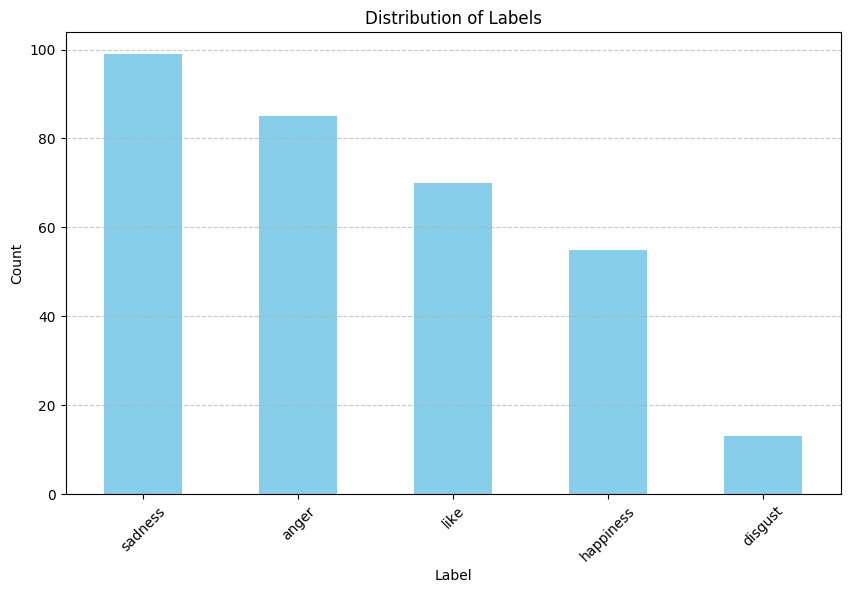

In [57]:
import pandas as pd
final = pd.DataFrame(columns=['comment', 'label'])
for idx, text in enumerate(data):
    final = final.append({'comment': text[0], 'label': results[idx]}, ignore_index=True)
label_counts = final['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

label_mapping1 = {
 '难过':'sadness',
'愉快':'happiness',
 '喜欢':'like',
 '愤怒':'anger',
'害怕':'fear',
 '惊讶':'surprise',
'厌恶':'disgust'
}
final['label'] = final['label'].map(label_mapping1)
label_counts = final['label'].value_counts()
print(label_counts)
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 